In [19]:
REBUILD_DATA = False # set to true to one once, then back to false unless you want to change something in your training data.

class DogsVSCats():
    IMG_SIZE = 50
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    TESTING = "PetImages/Testing"
    LABELS = {CATS: 0, DOGS: 1}
    training_data = []

    catcount = 0
    dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Cats:',dogsvcats.catcount)
        print('Dogs:',dogsvcats.dogcount)

if REBUILD_DATA:
    dogsvcats = DogsVSCats()
    dogsvcats.make_training_data()

  0%|▏                                                          | 28/12501 [00:00<00:45, 277.10it/s]

PetImages/Cat


  0%|▏                                                          | 29/12501 [00:00<00:44, 282.20it/s]

PetImages/Dog


100%|████████████████████████████████████████████████████████| 12501/12501 [00:41<00:00, 298.39it/s]


Cats: 12476
Dogs: 12470


In [20]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [22]:
print(len(training_data))

24946


In [23]:
print(training_data[1])

[array([[100,  91,  71, ..., 112,  86,  81],
       [ 35,  30,  41, ..., 113,  98,  93],
       [ 36,  27,  27, ..., 107, 203, 205],
       ...,
       [ 48,  49,  50, ..., 108, 107, 106],
       [ 50,  45,  50, ..., 108, 107, 105],
       [ 43,  42,  47, ..., 108, 107, 106]], dtype=uint8)
 array([0., 1.])]


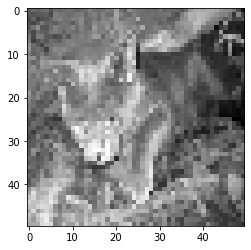

In [28]:
import matplotlib.pyplot as plt
plt.imshow(training_data[7][0], cmap="gray")
plt.show()

In [39]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5) ##kernel sizeis 5
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        
        self._to_linear = None
        self.convs(x) ##part of forward method
        
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512,2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self,x):
        x = self.convs(x)
        x = x.view(-1,self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x,dim=1)
    
net = Net()
        

In [40]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [41]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [42]:
BATCH_SIZE = 100
EPOCHS = 1
for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):

        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs,batch_y)
        loss.backward()
        optimizer.step()
        
print(loss)


 34%|█████████████████████▏                                        | 77/225 [01:58<03:38,  1.48s/it]


 69%|██████████████████████████████████████████                   | 155/225 [03:53<01:44,  1.49s/it]


100%|█████████████████████████████████████████████████████████████| 225/225 [05:36<00:00,  1.50s/it]

tensor(0.2636, grad_fn=<MseLossBackward>)


In [47]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print("Accuracy: ", round(correct/total,3))


 17%|██████████▍                                                 | 433/2494 [00:08<00:43, 47.93it/s]


 36%|█████████████████████▋                                      | 899/2494 [00:17<00:31, 51.33it/s]


 55%|████████████████████████████████▍                          | 1372/2494 [00:26<00:20, 53.70it/s]


 73%|██████████████████████████████████████████▉                | 1817/2494 [00:35<00:11, 61.27it/s]


 94%|███████████████████████████████████████████████████████▍   | 2345/2494 [00:44<00:02, 57.94it/s]


100%|███████████████████████████████████████████████████████████| 2494/2494 [00:46<00:00, 53.35it/s]

Accuracy:  0.581
